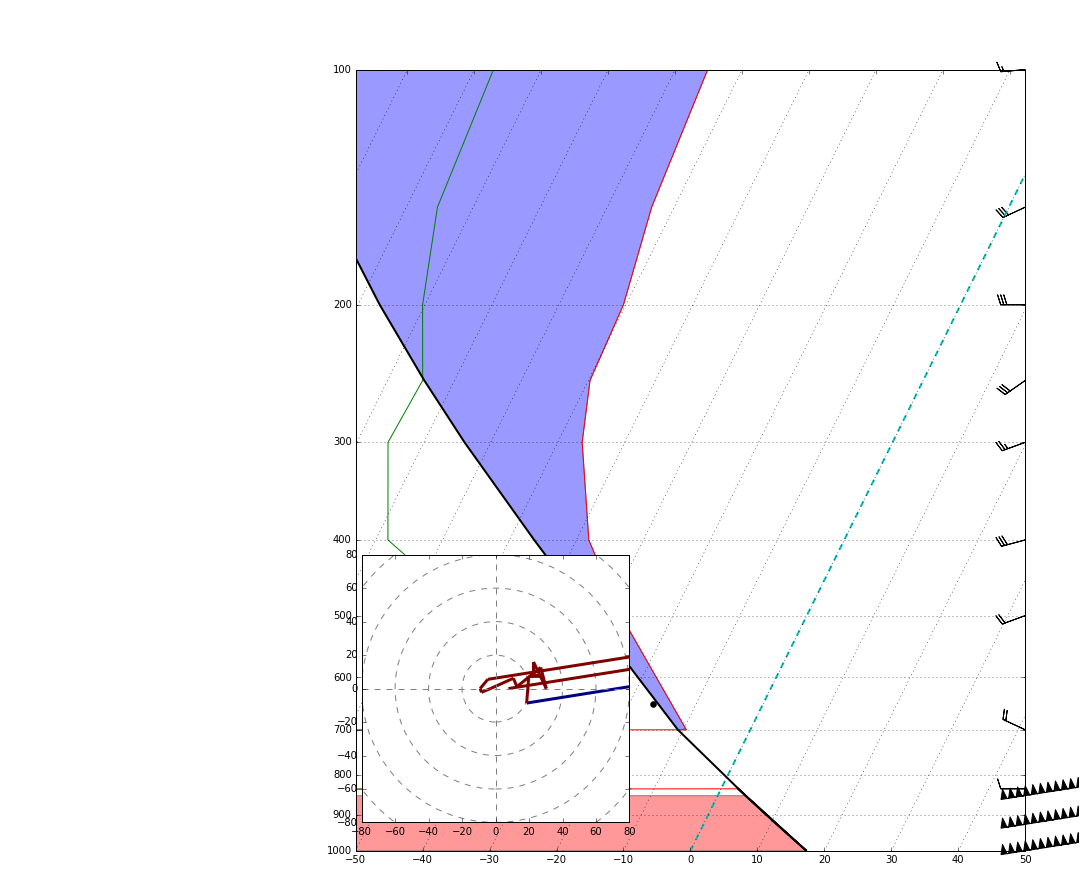

In [37]:
from awips.dataaccess import DataAccessLayer

import matplotlib.tri as mtri
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np

from metpy.calc import get_wind_components, lcl, dry_lapse, parcel_profile
from metpy.plots import SkewT, Hodograph
from metpy.units import units, concatenate

plt.rcParams['figure.figsize'] = (12, 14)

# Set EDEX host
DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest()

# Data type bufrua
request.setDatatype("bufrua")
# Parameters
request.setParameters("tpMan","tdMan","prMan","htMan","wdMan","wsMan")
# Station ID (name doesn't work yet)
request.setLocationNames("72469")
datatimes = DataAccessLayer.getAvailableTimes(request)

# Get most recent record
response = DataAccessLayer.getGeometryData(request,times=datatimes[-1].validPeriod)

# Initialize data arrays
tpMan,tdMan,prMan,htMan,wdMan,wsMan = [],[],[],[],[],[]

# Build ordered arrays
for ob in response:
    tpMan.append(float(ob.getString("tpMan")))
    tdMan.append(float(ob.getString("tdMan")))
    prMan.append(float(ob.getString("prMan")))
    htMan.append(float(ob.getString("htMan")))
    wdMan.append(float(ob.getString("wdMan")))
    wsMan.append(float(ob.getString("wsMan")))

# Convert 
# we can use units.* here?
T = np.array(tpMan)-273.15
Td = np.array(tdMan)-273.15
p = np.array(prMan)/100
height = np.array(htMan)
direc = np.array(wdMan)
spd = np.array(wsMan)
u, v = get_wind_components(spd, np.deg2rad(direc))

p = p * units.mbar
T = T * units.degC
Td = Td * units.degC
spd = spd * units.knot
direc = direc * units.deg

# Create a skewT plot
skew = SkewT()

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')
skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

# Calculate LCL height and plot as black dot
l = lcl(p[0], T[0], Td[0])
lcl_temp = dry_lapse(concatenate((p[0], l)), T[0])[-1].to('degC')
skew.plot(l, lcl_temp, 'ko', markerfacecolor='black')

# Calculate full parcel profile and add to plot as black line
prof = parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2)

# Example of coloring area between profiles
skew.ax.fill_betweenx(p, T, prof, where=T>=prof, facecolor='blue', alpha=0.4)
skew.ax.fill_betweenx(p, T, prof, where=T<prof, facecolor='red', alpha=0.4)

# An example of a slanted line at constant T -- in this case the 0 isotherm
l = skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Draw hodograph
ax_hod = inset_axes(skew.ax, '40%', '40%', loc=3)
h = Hodograph(ax_hod, component_range=80.)
h.add_grid(increment=20)
h.plot_colormapped(u, v, spd)

# Show the plot
plt.show()